# The Fisher Two-Period Optimal Consumption Problem

In [1]:
# Some initial setup
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
from copy  import deepcopy
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs
mystr = lambda number : "{:.3f}".format(number)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

This notebook creates interactive widgets illustrating a two-period optimal consumption problem. It also presents graphic representations of the decomposition of the effect of interest rates into the income, substitution, and human wealth effects.

### Basic Plot: the optimal $(c_1,c_2)$ bundle.

In [2]:
# The first step in creating a widget is defining
# a function that will receive the user's input as
# parameters and generate the entity that we want
# to analyze: in this case, a figure of the optimmal
# consumption bundle given income, assets, and interest
# rates

def FisherPlot(Y1, Y2, B1, R, c1Max, c2Max):
    
    # Basic setup of perfect foresight consumer
    
    # We first create an instance of the class
    # PerfForesightConsumerType, with its standard parameters.
    PFexample = PerfForesightConsumerType() 
    
    PFexample.cycles = 1 # let the agent live the cycle of periods just once
    PFexample.T_cycle = 2 # Number of periods in the cycle
    PFexample.PermGroFac = [1.] # No automatic growth in income across periods
    PFexample.LivPrb = [1.] # No chance of dying before the second period
    PFexample.aNrmInitStd = 0.
    PFexample.AgentCount = 1
    CRRA = PFexample.CRRA
    Beta = PFexample.DiscFac
    
    # Set interest rate and bank balances from input.
    PFexample.Rfree = R
    PFexample.aNrmInitMean = B1
    
    # Solve the model: this generates the optimal consumption function.
    
    # Try-except blocks "try" to execute the code in the try block. If an
    # error occurs, the except block is executed and the application does
    # not halt
    try:
        PFexample.solve()
    except:
        print('Those parameter values violate a condition required for solution!')
        
    # Create the figure
    c1Min = 0.
    c2Min = 0.
    plt.figure(figsize=(8,8))
    plt.xlabel('Period 1 Consumption $C_1$')
    plt.ylabel('Period 2 Consumption $C_2$')
    plt.ylim([c2Min,c2Max])
    plt.xlim([c1Min,c1Max])
    
    # Plot the budget constraint
    C1_bc = np.linspace(c1Min, B1 + Y1 + Y2/R, 10, endpoint=True)
    C2_bc = (Y1 + B1 - C1_bc)*R + Y2
    plt.plot(C1_bc, C2_bc, 'k-', label='Budget Constraint')
    
    # Plot the optimal consumption bundle
    C1 = PFexample.solution[0].cFunc(B1 + Y1 + Y2/R)
    C2 = PFexample.solution[1].cFunc((Y1 + B1 - C1)*R + Y2)
    plt.plot(C1, C2, 'ro', label='Optimal Consumption')
    
    # Plot the indifference curve
    V = C1**(1-CRRA)/(1-CRRA) + Beta*C2**(1-CRRA)/(1-CRRA) # Get max utility
    C1_V = np.linspace(((1-CRRA)*V)**(1/1-CRRA)+0.5, c1Max, 1000)
    C2_V = (((1-CRRA)*V - C1_V**(1-CRRA))/Beta)**(1/1-CRRA)
    plt.plot(C1_V, C2_V, 'b-', label='Indiferrence Curve')
    
    # Add a legend and display the plot
    plt.legend()
    plt.show()
    
    return None

In [3]:
# We now define the controls that will receive and transmit the
# user's input.
# These are sliders for which the range, step, display, and
# behavior are defined.

# Define a slider for the interest rate
Rfree_widget = widgets.FloatSlider(
    min=1.,
    max=2.,
    step=0.001,
    value=1.05,
    continuous_update=True,
    readout_format='.4f',
    description='$R$')

# Define a slider for Y1
Y1_widget = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=50.,
    continuous_update=True,
    readout_format='4f',
    description='$Y_1$')

# Define a slider for Y2
Y2_widget = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=50.,
    continuous_update=True,
    readout_format='4f',
    description='$Y_2$')

# Define a slider for B1
B1_widget = widgets.FloatSlider(
    min=0.,
    max=4.,
    step=0.01,
    value=2.,
    continuous_update=True,
    readout_format='4f',
    description='$B_1$')

# Define a textbox for C1 max
c1Max_widget = widgets.FloatText(
    value=120,
    step=1.,
    description='$C1$ max',
    disabled=False)

# Define a textbox for C2 max
c2Max_widget = widgets.FloatText(
    value=120,
    step=1.,
    description='$C2$ max',
    disabled=False)

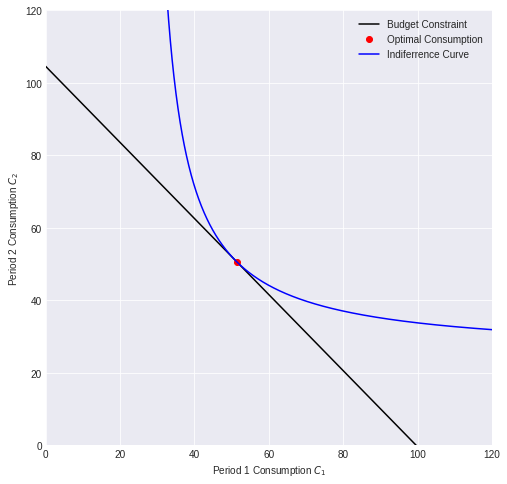

In [4]:
# Make the widget
interact(FisherPlot,
         Y1 = Y1_widget,
         Y2 = Y2_widget,
         B1 = B1_widget,
         R = Rfree_widget,
         c1Max = c1Max_widget,
         c2Max = c2Max_widget
        );

### Second plot: interest rate shifts with lifetime income earned in first period.

In [5]:
# This follows the same process as the previous plot, but now the problem
# is solved at two different interest rates in order to illustrate their effect.

# Define a function that plots something given some bits
def FisherPlot1(Y1, Y2, B1, RHi, RLo, c1Max, c2Max):
    
    # Basic setup of perfect foresight consumer
    PFexample = PerfForesightConsumerType() # set up a consumer type and use default parameteres  
    PFexample.cycles = 1 # let the agent live the cycle of periods just once
    PFexample.T_cycle = 2 # Number of periods in the cycle
    PFexample.PermGroFac = [1.] # No automatic growth in income across periods
    PFexample.LivPrb = [1.] # No chance of dying before the second period
    PFexample.aNrmInitStd = 0.
    PFexample.AgentCount = 1
    CRRA = 2.
    Beta = PFexample.DiscFac
    
    # Set the parameters we enter
    PFexample.aNrmInitMean = B1
    
    # Create two models, one for RfreeHigh and one for RfreeLow
    PFexampleRHi = deepcopy(PFexample)
    PFexampleRHi.Rfree = RHi
    PFexampleRLo = deepcopy(PFexample)
    PFexampleRLo.Rfree = RLo
    
    c1Min = 0.
    c2Min = 0.
    
    # Solve the model for RfreeHigh and RfreeLow
    try:
        PFexampleRHi.solve()
        PFexampleRLo.solve()
    except:
        print('Those parameter values violate a condition required for solution!')
        
    # Plot the chart
    plt.figure(figsize=(8,8))
    plt.xlabel('Period 1 Consumption $C_1$')
    plt.ylabel('Period 2 Consumption $C_2$')
    plt.ylim([c2Min,c2Max])
    plt.xlim([c1Min,c1Max])
    
    # Plot the budget constraints    
    C1_bc_RLo = np.linspace(c1Min, B1 + Y1 + Y2/RLo, 10, endpoint=True)
    C2_bc_RLo = (Y1 + B1 - C1_bc_RLo)*RLo + Y2
    plt.plot(C1_bc_RLo, C2_bc_RLo, 'k-', label='Budget Constraint R Low')
    
    C1_bc_RHi = np.linspace(c1Min, B1 + Y1 + Y2/RHi, 10, endpoint=True)
    C2_bc_RHi = (Y1 + B1 - C1_bc_RHi)*RHi + Y2
    plt.plot(C1_bc_RHi, C2_bc_RHi, 'k--', label='Budget Constraint R High')
    
    # The optimal consumption bundles
    C1_opt_RLo = PFexampleRLo.solution[0].cFunc(B1 + Y1 + Y2/RLo)
    C2_opt_RLo = PFexampleRLo.solution[1].cFunc((Y1 + B1 - C1_opt_RLo)*RLo + Y2)
    
    C1_opt_RHi = PFexampleRHi.solution[0].cFunc(B1 + Y1 + Y2/RHi)
    C2_opt_RHi = PFexampleRHi.solution[1].cFunc((Y1 + B1 - C1_opt_RHi)*RHi + Y2)
    
    # Plot the indifference curves    
    V_RLo = C1_opt_RLo**(1-CRRA)/(1-CRRA) + Beta*C2_opt_RLo**(1-CRRA)/(1-CRRA) # Get max utility
    C1_V_RLo = np.linspace(((1-CRRA)*V_RLo)**(1/(1-CRRA))+0.5, c1Max, 1000)
    C2_V_RLo = (((1-CRRA)*V_RLo - C1_V_RLo**(1-CRRA))/Beta)**(1/(1-CRRA))
    plt.plot(C1_V_RLo, C2_V_RLo, 'b-', label='Indiferrence Curve R Low')
    
    V_RHi = C1_opt_RHi**(1-CRRA)/(1-CRRA) + Beta*C2_opt_RHi**(1-CRRA)/(1-CRRA) # Get max utility
    C1_V_RHi = np.linspace(((1-CRRA)*V_RHi)**(1/(1-CRRA))+0.5, c1Max, 1000)
    C2_V_RHi = (((1-CRRA)*V_RHi - C1_V_RHi**(1-CRRA))/Beta)**(1/(1-CRRA))
    plt.plot(C1_V_RHi, C2_V_RHi, 'b--', label='Indiferrence Curve R High')
    
    # The substitution effect
    C1_Subs = (V_RHi*(1-CRRA)/(1+Beta*(RLo*Beta)**((1-CRRA)/CRRA)))**(1/(1-CRRA))
    C2_Subs = C1_Subs*(RLo*Beta)**(1/CRRA)
    
    C1_bc_Subs = np.linspace(c1Min, B1 + Y1 + Y2/RHi, 10, endpoint=True)
    C2_bc_Subs = (C1_Subs + C2_Subs/RLo - C1_bc_Subs)*RLo + Y2
    plt.plot(C1_bc_Subs, C2_bc_Subs, 'k-')
    
    # Plot the points of interest
    plt.plot(C1_opt_RLo, C2_opt_RLo, 'ro', label='A: Optimal Consumption R Low')
    plt.plot(C1_Subs, C2_Subs, 'go', label='B: Income effect AB \n     Substitution effect BC ')
    plt.plot(C1_opt_RHi, C2_opt_RHi, 'mo', label='C: Optimal Consumption R High')
    
    plt.legend()
    plt.show()
    
    return None

In [6]:
# Define some widgets to control the plot

# Define a slider for the high interest rate
RHi_widget1 = widgets.FloatSlider(
    min=1.,
    max=4.,
    step=0.01,
    value=2,
    continuous_update=True,
    readout_format='.2f',
    description='$R High$')

# Define a slider for the low interest rate
RLo_widget1 = widgets.FloatSlider(
    min=0.,
    max=4.,
    step=0.01,
    value=1.0,
    continuous_update=True,
    readout_format='.2f',
    description='$R Low$')

# Define a slider for Y1
Y1_widget1 = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=100.,
    continuous_update=True,
    readout_format='.1f',
    description='$Y_1$')

# Define a slider for Y2
Y2_widget1 = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=0.,
    continuous_update=True,
    readout_format='.1f',
    description='$Y_2$')

# Define a slider for B1
B1_widget1 = widgets.FloatSlider(
    min=0.,
    max=4.,
    step=0.01,
    value=0.,
    continuous_update=True,
    readout_format='.1f',
    description='$B_1$')

# Define a textbox for C1 max
c1Max_widget1 = widgets.FloatText(
    value=120,
    step=1.,
    description='$C1$ max',
    disabled=False)

# Define a textbox for C2 max
c2Max_widget1 = widgets.FloatText(
    value=120,
    step=1.,
    description='$C2$ max',
    disabled=False)

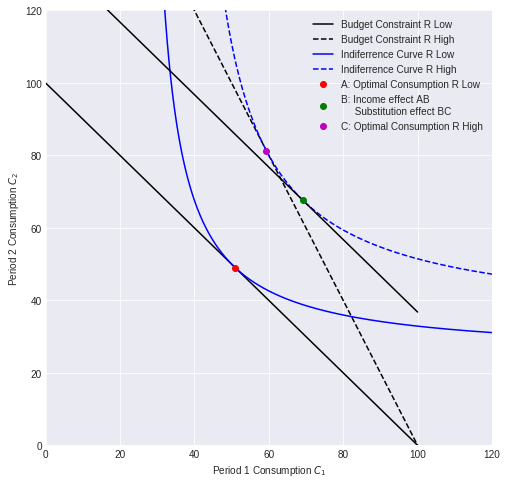

In [7]:
# Make the widget

interact(FisherPlot1,
         Y1 = Y1_widget1,
         Y2 = fixed(0.),
         B1 = B1_widget1,
         RHi = RHi_widget1,
         RLo = RLo_widget1,
         c1Max = c1Max_widget1,
         c2Max = c2Max_widget1
        );

### Third plot: interest rate shifts with lifetime income earned in second period

In [8]:
# This follows the same process, but we now fix Y_1 at 0

# Define a function that plots something given some bits
def FisherPlot2(Y1, Y2, B1, RHi, RLo, c1Max, c2Max):
    
    # Basic setup of perfect foresight consumer
    PFexample = PerfForesightConsumerType() # set up a consumer type and use default parameteres  
    PFexample.cycles = 1 # let the agent live the cycle of periods just once
    PFexample.T_cycle = 2 # Number of periods in the cycle
    PFexample.PermGroFac = [1.] # No automatic growth in income across periods
    PFexample.LivPrb = [1.] # No chance of dying before the second period
    PFexample.aNrmInitStd = 0.
    PFexample.AgentCount = 1
    CRRA = 2.
    Beta = PFexample.DiscFac
    
    # Set the parameters we enter
    PFexample.aNrmInitMean = B1
    
    # Create two models, one for RfreeHigh and one for RfreeLow
    PFexampleRHi = deepcopy(PFexample)
    PFexampleRHi.Rfree = RHi
    PFexampleRLo = deepcopy(PFexample)
    PFexampleRLo.Rfree = RLo
    
    c1Min = 0.
    c2Min = 0.
    
    # Solve the model for RfreeHigh
    try:
        PFexampleRHi.solve()
        PFexampleRLo.solve()
    except:
        print('Those parameter values violate a condition required for solution!')
        
    # Plot the chart
    plt.figure(figsize=(8,8))
    plt.xlabel('Period 1 Consumption $C_1$')
    plt.ylabel('Period 2 Consumption $C_2$')
    plt.ylim([c2Min,c2Max])
    plt.xlim([c1Min,c1Max])
    
    # Plot the budget constraints    
    C1_bc_RLo = np.linspace(c1Min, B1 + Y1 + Y2/RLo, 10, endpoint=True)
    C2_bc_RLo = (Y1 + B1 - C1_bc_RLo)*RLo + Y2
    plt.plot(C1_bc_RLo, C2_bc_RLo, 'k-', label='Budget Constraint R Low')
    
    C1_bc_RHi = np.linspace(c1Min, B1 + Y1 + Y2/RHi, 10, endpoint=True)
    C2_bc_RHi = (Y1 + B1 - C1_bc_RHi)*RHi + Y2
    plt.plot(C1_bc_RHi, C2_bc_RHi, 'k--', label='Budget Constraint R High')
    
    # The optimal consumption bundles
    C1_opt_RLo = PFexampleRLo.solution[0].cFunc(B1 + Y1 + Y2/RLo)
    C2_opt_RLo = PFexampleRLo.solution[1].cFunc((Y1 + B1 - C1_opt_RLo)*RLo + Y2)
    
    C1_opt_RHi = PFexampleRHi.solution[0].cFunc(B1 + Y1 + Y2/RHi)
    C2_opt_RHi = PFexampleRHi.solution[1].cFunc((Y1 + B1 - C1_opt_RHi)*RHi + Y2)
    
    # Plot the indifference curves    
    V_RLo = C1_opt_RLo**(1-CRRA)/(1-CRRA) + Beta*C2_opt_RLo**(1-CRRA)/(1-CRRA) # Get max utility
    C1_V_RLo = np.linspace(((1-CRRA)*V_RLo)**(1/(1-CRRA))+0.5, c1Max, 1000)
    C2_V_RLo = (((1-CRRA)*V_RLo - C1_V_RLo**(1-CRRA))/Beta)**(1/(1-CRRA))
    plt.plot(C1_V_RLo, C2_V_RLo, 'b-', label='Indiferrence Curve R Low')
    
    V_RHi = C1_opt_RHi**(1-CRRA)/(1-CRRA) + Beta*C2_opt_RHi**(1-CRRA)/(1-CRRA) # Get max utility
    C1_V_RHi = np.linspace(((1-CRRA)*V_RHi)**(1/(1-CRRA))+0.5, c1Max, 1000)
    C2_V_RHi = (((1-CRRA)*V_RHi - C1_V_RHi**(1-CRRA))/Beta)**(1/(1-CRRA))
    plt.plot(C1_V_RHi, C2_V_RHi, 'b--', label='Indiferrence Curve R High')
    
    # The substitution effect
    C1_Subs = (V_RHi*(1-CRRA)/(1+Beta*(RLo*Beta)**((1-CRRA)/CRRA)))**(1/(1-CRRA))
    C2_Subs = C1_Subs*(RLo*Beta)**(1/CRRA)
    
    # The Human wealth effect
    Y2HW = Y2*RLo / RHi
    C1HW = Y2HW / (RLo+(RLo)**(1/CRRA))
    C2HW = C1HW*(RLo*Beta)**(1/CRRA)
    
    C1_bc_HW = np.linspace(c1Min, B1 + Y1 + Y2HW/RLo, 10, endpoint=True)
    C2_bc_HW = (Y1 + B1 - C1_bc_HW)*RLo + Y2HW
    plt.plot(C1_bc_HW, C2_bc_HW, 'k:')
    
    VHW = (C1HW**(1-CRRA))/(1-CRRA) + (Beta*C2HW**(1-CRRA))/(1-CRRA)
    C1_V_HW = np.linspace(((1-CRRA)*VHW)**(1/(1-CRRA))+0.5, c1Max, 1000)
    C2_V_HW = (((1-CRRA)*VHW - C1_V_HW**(1-CRRA))/Beta)**(1/(1-CRRA))
    plt.plot(C1_V_HW, C2_V_HW, 'b:')
    
    # Plot the points of interest
    plt.plot(C1_opt_RLo, C2_opt_RLo, 'ro', label='A: Optimal Consumption R Low')
    plt.plot(C1_Subs, C2_Subs, 'go', label='B: Income effect DB \n    Substitution effect BC')
    plt.plot(C1_opt_RHi, C2_opt_RHi, 'mo', label='C: Optimal Consumption R High')
    plt.plot(C1HW, C2HW, 'co', label='D: HW effect AD')
    
    plt.legend()
    plt.show()
    
    return None

In [9]:
# Define some widgets to control the plot

# Define a slider for the high interest rate
RHi_widget2 = widgets.FloatSlider(
    min=1.,
    max=4.,
    step=0.01,
    value=2,
    continuous_update=True,
    readout_format='.2f',
    description='$R High$')

# Define a slider for the low interest rate
RLo_widget2 = widgets.FloatSlider(
    min=0.,
    max=4.,
    step=0.01,
    value=1.0,
    continuous_update=True,
    readout_format='.2f',
    description='$R Low$')

# Define a slider for Y1
Y1_widget2 = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=100.,
    continuous_update=True,
    readout_format='.1f',
    description='$Y_1$')

# Define a slider for Y2
Y2_widget2 = widgets.FloatSlider(
    min=0.,
    max=100.,
    step=0.1,
    value=100.,
    continuous_update=True,
    readout_format='.1f',
    description='$Y_2$')

# Define a slider for B1
B1_widget2 = widgets.FloatSlider(
    min=0.,
    max=4.,
    step=0.01,
    value=0.,
    continuous_update=True,
    readout_format='.1f',
    description='$B_1$')

# Define a textbox for C1 max
c1Max_widget2 = widgets.FloatText(
    value=120,
    step=1.,
    description='$C1$ max',
    disabled=False)

# Define a textbox for C2 max
c2Max_widget2 = widgets.FloatText(
    value=120,
    step=1.,
    description='$C2$ max',
    disabled=False)

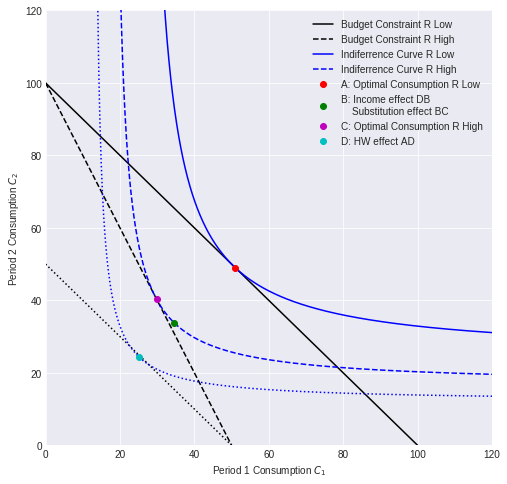

In [10]:
# Make the widget

interact(FisherPlot2,
         Y1 = fixed(0.),
         Y2 = Y2_widget2,
         B1 = fixed(0.),
         RHi = RHi_widget2,
         RLo = RLo_widget2,
         c1Max = c1Max_widget2,
         c2Max = c2Max_widget2
        );